In [1]:
import numpy as np
import pandas as pd
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [2]:
%%time

train_df = pd.read_csv('train.csv') #read train dataset
test_df = pd.read_csv('test.csv') # read test dataset
print(train_df.shape, test_df.shape)

(2249698, 6) (734736, 5)
Wall time: 1min 4s


<AxesSubplot:>

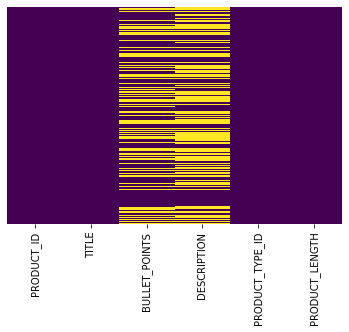

In [3]:
import seaborn as sns
sns.heatmap(train_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

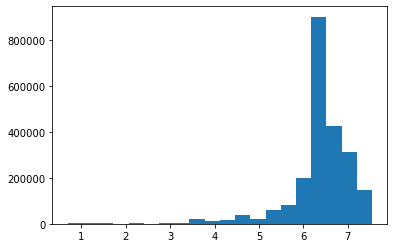

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.hist(train_df['target'],bins=20)
plt.show()


In [8]:
round((train_df.isnull().sum())/train_df.shape[0]*100,2)

PRODUCT_ID          0.00
TITLE               0.00
BULLET_POINTS      37.22
DESCRIPTION        51.45
PRODUCT_TYPE_ID     0.00
PRODUCT_LENGTH      0.00
dtype: float64

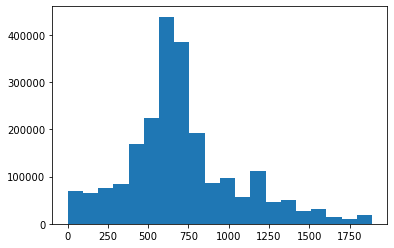

In [41]:
plt.hist(train_df['PRODUCT_LENGTH'], bins=20)
plt.show()

In [34]:
train_df.BULLET_POINTS[9]

'[100% Pure And Natural Essential Oil Or Fragrance Oil, Each Bottle in 10ml of aromatherapy essential oils available.,This essential oil set could be used in professional environments like massage facilities, beauty salons and offices, or used to diffuse/humidify the air in the rooms.,For those who love DIY, these essential oils could be perfect for baths, body and hair care, homemade lotions, candles, candle wax, soy wax, soap base, perfumes, cleaning, art & craft projects, pine cones, incense sticks or cones, other unscented products and so much more!,We have this types of Aromas Essential Diffuser oil of Lavender Oil, Rose Oil, Tea Tree Oil, Rosemary Oil, Jasmine Oil, Rajnigandha Oil, Eucalyptus Oil, Lemongrass Oil, Orchid Oil & Sandalwood Oil,A perfect gift for everyday use.]'

In [43]:
train_df["PRODUCT_LENGTH"].describe()

count    2.249698e+06
mean     7.063885e+02
std      3.536603e+02
min      1.000000e+00
25%      5.118110e+02
50%      6.630000e+02
75%      8.500000e+02
max      1.889764e+03
Name: PRODUCT_LENGTH, dtype: float64

In [22]:
#Eliminate all the outliers in the PRODUCT_LENGTH column using IQR method
outliers = []
def detect_outliers_iqr(data):
    median = data['PRODUCT_LENGTH'].median()

    q1 = np.percentile(data['PRODUCT_LENGTH'], 25)
    q3 = np.percentile(data['PRODUCT_LENGTH'], 75)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    count =0
    for i in range(len(data['PRODUCT_LENGTH'])): 
        if (data.iat[i,-1]<lwr_bound or data.iat[i,-1]>upr_bound):
            data.iat[i,-1] = median
            count = count +1 
    return count
count = detect_outliers_iqr(train_df)
print("Outliers from IQR method: ", count)


Outliers from IQR method:  208533


In [44]:
# Handle missing data.
def fill_missing_values(df):
    df.TITLE.fillna(value="Missing", inplace=True)
    df.BULLET_POINTS.fillna(value="Missing", inplace=True)
    df.DESCRIPTION.fillna(value="Missing", inplace=True)
    return df

train_df = fill_missing_values(train_df)
test_df = fill_missing_values(test_df)

In [45]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [46]:
punctuation_symbols = []
for symbol in punctuation:
    punctuation_symbols.append((symbol, ''))
    
punctuation_symbols

[('!', ''),
 ('"', ''),
 ('#', ''),
 ('$', ''),
 ('%', ''),
 ('&', ''),
 ("'", ''),
 ('(', ''),
 (')', ''),
 ('*', ''),
 ('+', ''),
 (',', ''),
 ('-', ''),
 ('.', ''),
 ('/', ''),
 (':', ''),
 (';', ''),
 ('<', ''),
 ('=', ''),
 ('>', ''),
 ('?', ''),
 ('@', ''),
 ('[', ''),
 ('\\', ''),
 (']', ''),
 ('^', ''),
 ('_', ''),
 ('`', ''),
 ('{', ''),
 ('|', ''),
 ('}', ''),
 ('~', '')]

In [47]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ajain\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [49]:
import string

# Create a function to remove punctuations
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))

# Create a function to remove stop words
def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

# Create a function to lowercase the words
def to_lower(x):
    return x.lower()

# Create a function to remove emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [50]:
# Scale target variable to log.
train_df = non_norm_train
train_df['target'] = np.log1p(train_df['PRODUCT_LENGTH'])

Y_train = train_df.target.values.reshape(-1,1)

# Calculate number of train/dev/test examples.
n_trains = train_df.shape[0]
print("Training on", n_trains, "examples")

Training on 2249698 examples


In [51]:
full_df = pd.concat([train_df, test_df]) #combine the train and test datasets

In [ ]:
%%time
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
full_df['DESCRIPTION'] = full_df['DESCRIPTION'].apply(porter.stem)
full_df['DESCRIPTION'] = full_df['DESCRIPTION'].apply(remove_emoji)
full_df['DESCRIPTION'] = full_df['DESCRIPTION'].apply(remove_punctuation)
full_df['DESCRIPTION'] = full_df['DESCRIPTION'].apply(remove_stop_words)
full_df['DESCRIPTION'] = full_df['DESCRIPTION'].apply(to_lower)

full_df['TITLE'] = full_df['TITLE'].apply(remove_punctuation)
full_df['TITLE'] = full_df['TITLE'].apply(remove_emoji)
full_df['TITLE'] = full_df['TITLE'].apply(remove_stop_words)
full_df['TITLE'] = full_df['TITLE'].apply(to_lower)

full_df['BULLET_POINTS'] = full_df['BULLET_POINTS'].apply(porter.stem)
full_df['BULLET_POINTS'] = full_df['BULLET_POINTS'].apply(remove_emoji)
full_df['BULLET_POINTS'] = full_df['BULLET_POINTS'].apply(remove_punctuation)
full_df['BULLET_POINTS'] = full_df['BULLET_POINTS'].apply(remove_stop_words)
full_df['BULLET_POINTS'] = full_df['BULLET_POINTS'].apply(to_lower)

In [ ]:
full_df.drop('PRODUCT_ID', axis=1, inplace=True) #drop PRODUCT_ID column

In [ ]:
%%time

# Convert data type to string
full_df['PRODUCT_TYPE_ID'] = full_df['PRODUCT_TYPE_ID'].astype(str)

In [ ]:
%%time
#Vectorization of the data in the columns
print("Vectorizing data...")
default_preprocessor = CountVectorizer().build_preprocessor()
def build_preprocessor(field):
    field_idx = list(full_df.columns).index(field)
    return lambda x: default_preprocessor(x[field_idx])

vectorizer = FeatureUnion([
    ('TITLE', CountVectorizer(
        ngram_range=(1, 1),
        max_features=None,
        preprocessor=build_preprocessor('TITLE'))),
    ('PRODUCT_TYPE_ID', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('PRODUCT_TYPE_ID'))),
    ('DESCRIPTION', TfidfVectorizer(
        ngram_range=(1, 1),
        max_features=None,
        preprocessor=build_preprocessor('DESCRIPTION'))),
    ('BULLET_POINTS', TfidfVectorizer(
        ngram_range=(1, 1),
        max_features=None,
        preprocessor=build_preprocessor('BULLET_POINTS'))),
])

X = vectorizer.fit_transform(full_df.values) #sparse matrix containing all the vectorized columns

In [ ]:
# split the combined sparse matrix into train and test
X_train = X[:n_trains] 
X_test = X[n_trains:]

In [ ]:
print(X.shape, X_train.shape, X_test.shape, Y_train.shape)

In [ ]:
%%time
#Train a Ridge Regression model on the obtained X_train and Y_train 
print("Fitting Ridge model on training examples...")
ridge_model = Ridge(
    solver='auto', fit_intercept=True, alpha=15,
    max_iter=60, normalize=False, tol=0.05,
)
ridge_model.fit(X_train, Y_train)

In [ ]:
%%time

ridge_preds = ridge_model.predict(X_test) #predict X_test using the trained Ridge model
ridge_preds = np.expm1(ridge_preds) # perform anti-log

In [ ]:
ridge_preds # is the final 2x2 array containing the PRODUCT_LENGTHs of the test dataset
test_df['PRODUCT_LENGTH'] = ridge_preds
test_df['PRODUCT_LENGTH'] = test_df['PRODUCT_LENGTH'].apply(pd.Series).astype(int) #convert the array into int
test_df.drop(['TITLE', 'BULLET_POINTS', 'DESCRIPTION', 'PRODUCT_TYPE_ID'], axis=1, inplace=True) 
test_df.to_csv('final_predicted_lengths.csv')
test_df